In [3]:
!pip install --user pymbar

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 100 kB 5.3 MB/s ta 0:00:011
You should consider upgrading via the '/cm/local/apps/python37/bin/python3 -m pip install --upgrade pip' command.


In [1]:
%cd /data/wesley/mbar_example
!ls

/data/wesley/mbar_example
README.md  mbar_example.ipynb


In [2]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import bokeh as bk
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

import ipywidgets as widgets
from ipywidgets import interact,interact_manual

import tqdm

import pymbar as pmb
output_notebook()

Loading BokehJS ...

In [3]:
class Simple_1D_BD_Sim:
    def __init__(
        self, 
        potential_gradient_function,
        parameter_dict=None, 
        starting_coordinates=0, #technically 'coordinate' since this is 1D #1D function,takes a coordinate (x) and yields grad(U(x)). I.e. dU/dx
    ):
        self.kb=0.001985875 #kcal/(mol*K)
        self.parameter_dict=dict(
            diffusionConstant=1.0, #in Å**2/(fs) -> i.e. square distance per time unit
            temperature=310.15, # Kelvins (default = normal body temperature),
            vmax=1.5, #maximum allowed velocity (violation will terminate simulation due to instability)
            trajectorySnapshotRate=100, #number of steps between saving to trajectory data
            periodicBoundaryLength=None,
            timestep=1.0, #time step in fs
            verbose=False,
        )
        if not (parameter_dict is None):
            self.set_parameters(parameter_dict)
        if not (starting_coordinates is None):
            self.x0=starting_coordinates
        else:
            self.x0=0
            
        self.set_potential_gradient_function(potential_gradient_function)
        
        
    def set_parameters(self,parameter_dict):
        for parameterName in parameter_dict:
            if parameterName in self.parameter_dict: #make sure we dont add unsupported parameters
                self.parameter_dict[parameterName]=parameter_dict[parameterName]
            elif self.parameter_dict['verbose']:
                print('Warning: parameter "%s" not supported'%(str(parameterName)))
    
    def set_potential_gradient_function(self,potential_gradient_function):
        self.potential_gradient_function=potential_gradient_function
   
    def set_x0(self,x0):
        self.x0=x0
        
    def run_sim(
        self,
        nsteps=10000,
        giveVelocities=False,
        randomSeed=None,
        pbar=None,
    ):
        
        x=self.x0
        bPBL=self.parameter_dict['periodicBoundaryLength']
        if not (bPBL is None):
            x=x%bPBL
        bD=self.parameter_dict['diffusionConstant']
        kb=self.kb
        bT=self.parameter_dict['temperature']
        trajInterval=self.parameter_dict['trajectorySnapshotRate']
        verbose=self.parameter_dict['verbose']
        bVmax=self.parameter_dict['vmax']
        ts=self.parameter_dict['timestep']
        gradUfun=self.potential_gradient_function
        print(nsteps)
        if not (randomSeed is None): #in case we want to specify a specific random seed for reproducibility
            np.random.seed(randomSeed)
        trajectoryData=np.zeros(int(nsteps/trajInterval))
        if giveVelocities:
            velocityData=np.zeros(nsteps)
        
        tStep=0    
        stable=True
        # X'(t)=-D/(kbT)*grad(U(X))+√(2D)*R(t)
        #R -> stationary gaussian process
        while (tStep<nsteps) and stable:
            v=( -bD/(kb*bT)*gradUfun(x)+np.sqrt(2*bD)*np.random.normal(scale=1/np.sqrt(ts)) )*ts
            if (tStep%trajInterval) == 0:
                trajectoryData[int(tStep/trajInterval)]=x
                if giveVelocities:
                    velocityData[int(tStep/trajInterval)]=v
            if np.abs(v)>bVmax:
                stable=False
                if verbose:
                    print(
                        ("ERROR (step %g): velocity (%.3e) exceeds maximum (%.3e),"+\
                        "simulation terminated due to instability")%(
                            tStep,v,bVmax
                        )
                    )
            if not pbar is None:
                pbar.update()
            x=x+v
            if not (bPBL is None):
                x=x%bPBL
            tStep=tStep+1
        outDict=dict(
            trajectory=trajectoryData[:(int(tStep/trajInterval)+1)]
        )
        if giveVelocities:
            outDict['velocities']=velocityData[:(int(tStep/trajInterval)+1)]
        return(outDict)

'kbT/2=3.080E-01'

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1000000
<v**2>/2=0.24822893 at D=0.250 fs; <|v|>=0.56283685 at timestep=1.000; total steps = 1e+06 (1.0000 ns)



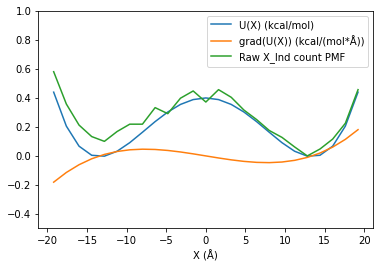

In [4]:
def potFunTest(x):
    return (1./80000.)*x**4+(.4-(.45/100)*x**2)
def potGradFunTest(x):
    return 4*(1./80000)*x**3-2*(.45/100)*x
    
diffCoef=.25
sim_dt=1.0
bd_TestSim=Simple_1D_BD_Sim(potGradFunTest)
bd_TestSim.set_parameters(dict(
    diffusionConstant=diffCoef,
    vmax=15.0,
    trajectorySnapshotRate=int(100/sim_dt),
    verbose=True,
    timestep=sim_dt
))
bd_TestSim.set_x0(0.)

display(
    'kbT/2=%.3E'%(
        bd_TestSim.parameter_dict['temperature']*bd_TestSim.kb/2.
    )
)


binEdges=np.linspace(-20,20,26)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
xgrid=binCenters#np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFunTest(xgrid),
    label='U(X) (kcal/mol)'
)
sns.lineplot(
    x=xgrid,
    y=potGradFunTest(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)
plt.ylim(-.5,1.)
plt.xlabel('X (Å)')

bd_TestSim.set_x0(0.)
nsteps=int(1000000/sim_dt) #100000000
trajTestData=bd_TestSim.run_sim(
    nsteps=nsteps,
    giveVelocities=True,
    pbar=tqdm.tqdm_notebook(total=nsteps))

kb=bd_TestSim.kb
kbT=bd_TestSim.kb*bd_TestSim.parameter_dict['temperature']
dt=bd_TestSim.parameter_dict['timestep']
print(
    '<v**2>/2={hvsq:.8f} at D={D:.3f} fs'.format(
        D=bd_TestSim.parameter_dict['diffusionConstant'],
        hvsq=np.mean((trajTestData['velocities']/dt)**2/2.))+ \
    '; <|v|>={v:.8f} at timestep={ts:.3f}'.format(
        ts=bd_TestSim.parameter_dict['timestep'],
        v=np.mean(np.abs(trajTestData['velocities'])/dt))+ \
    '; total steps = {nts:g} ({simtime:.4f} ns)'.format(
        nts=nsteps, simtime=nsteps*bd_TestSim.parameter_dict['timestep']*1E-6
    )
)
xgrid=binCenters
test_pmf_hist=np.histogram(
    a=trajTestData['trajectory'],
    bins=binEdges
)
test_pmf_vec=test_pmf_hist[0]
test_pmf_vec=test_pmf_vec/np.sum(test_pmf_vec)
test_pmf_vec=-kbT*np.log(test_pmf_vec/np.max(test_pmf_vec))
sns.lineplot(
    x=xgrid,
    y=test_pmf_vec,
    label='Raw X_Ind count PMF'
)
plt.ylim(-.5,1.)
plt.show()

plt.show()


In [5]:
def gen_harmonic_window_potFun(potFun,win_center,kval):
    return(
        lambda x: potFun(x)+.5*kval*(x-win_center)**2
    )
def gen_harmonic_window_potGradFun(potGradFun,window_center,kval):
    return(
        lambda x: potGradFun(x)-kval*(window_center-x)
    )

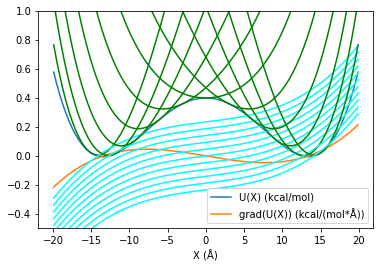

In [8]:
windowCenters=np.linspace(-15,15,11)
windowKvals=np.array([2**-6]*len(windowCenters))
window_potFuns=[
    gen_harmonic_window_potFun(potFunTest,wc,wk) \
    for wc,wk in zip(windowCenters,windowKvals)
]
window_potGradFuns=[
    gen_harmonic_window_potGradFun(potGradFunTest,wc,wk) \
    for wc,wk in zip(windowCenters,windowKvals)
]

binEdges=np.linspace(-20,20,201)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
xgrid=binCenters#np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFunTest(xgrid),
    label='U(X) (kcal/mol)'
)
sns.lineplot(
    x=xgrid,
    y=potGradFunTest(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)
plt.ylim(-.5,1.)
plt.xlabel('X (Å)')

for iWin,windowCenter in enumerate(windowCenters):
    sns.lineplot(
        x=xgrid,
        y=window_potFuns[iWin](xgrid),
        #label='U(X) (kcal/mol)',
        color='green'
    )
    sns.lineplot(
        x=xgrid,
        y=window_potGradFuns[iWin](xgrid),
        #label='grad(U(X)) (kcal/(mol*Å))',
        color='cyan'
    )

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.25364624 at D=0.250 fs; <|v|>=0.56897758 at timestep=1.000; total steps = 500000 (0.5000 ns)



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.26153595 at D=0.250 fs; <|v|>=0.57958134 at timestep=1.000; total steps = 500000 (0.5000 ns)



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.25693318 at D=0.250 fs; <|v|>=0.56875055 at timestep=1.000; total steps = 500000 (0.5000 ns)


/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.24727816 at D=0.250 fs; <|v|>=0.56034540 at timestep=1.000; total steps = 500000 (0.5000 ns)



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.25715551 at D=0.250 fs; <|v|>=0.56959927 at timestep=1.000; total steps = 500000 (0.5000 ns)



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.24886203 at D=0.250 fs; <|v|>=0.56443537 at timestep=1.000; total steps = 500000 (0.5000 ns)


/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.24847023 at D=0.250 fs; <|v|>=0.56118564 at timestep=1.000; total steps = 500000 (0.5000 ns)



/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.24753370 at D=0.250 fs; <|v|>=0.55973079 at timestep=1.000; total steps = 500000 (0.5000 ns)


/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.25384502 at D=0.250 fs; <|v|>=0.56727951 at timestep=1.000; total steps = 500000 (0.5000 ns)




/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.24760920 at D=0.250 fs; <|v|>=0.56327783 at timestep=1.000; total steps = 500000 (0.5000 ns)





/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log
/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


500000
<v**2>/2=0.25465198 at D=0.250 fs; <|v|>=0.57055439 at timestep=1.000; total steps = 500000 (0.5000 ns)


/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


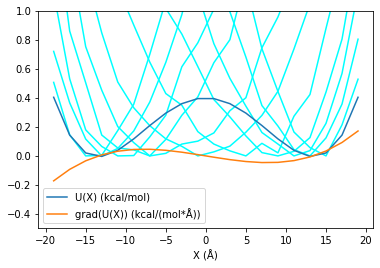

In [9]:
sim_dt=1.0 #fs
diffCoef=.25
simChemTime=.50 #ns
snapRate=100
nsteps=int(simChemTime*1E6/sim_dt)
nSnaps=int(nsteps/snapRate)

binEdges=np.linspace(-20,20,21)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
window_sim_data=[np.zeros(nsteps)]*len(windowCenters)
for iWin,windowCenter in enumerate(windowCenters): #[5:6]):
    windowK=windowKvals[iWin]
    bd_TestSim=Simple_1D_BD_Sim(window_potGradFuns[iWin])
    bd_TestSim.set_parameters(dict(
        diffusionConstant=diffCoef,
        vmax=15.0,
        trajectorySnapshotRate=snapRate,
        verbose=True,
        timestep=sim_dt
    ))
    bd_TestSim.set_x0(windowCenters[iWin])
    #nsteps=int(2000000/sim_dt) #100000000
    trajTestData
    window_sim_data[iWin]=bd_TestSim.run_sim(
        nsteps=nsteps,
        giveVelocities=True,
        pbar=tqdm.tqdm_notebook(total=nsteps))

    trajTestData=window_sim_data[iWin]
    kb=bd_TestSim.kb
    dt=bd_TestSim.parameter_dict['timestep']
    print(
        '<v**2>/2={hvsq:.8f} at D={D:.3f} fs'.format(
            D=bd_TestSim.parameter_dict['diffusionConstant'],
            hvsq=np.mean((trajTestData['velocities']/dt)**2/2.))+ \
        '; <|v|>={v:.8f} at timestep={ts:.3f}'.format(
            ts=bd_TestSim.parameter_dict['timestep'],
            v=np.mean(np.abs(trajTestData['velocities'])/dt))+ \
        '; total steps = {nts:g} ({simtime:.4f} ns)'.format(
            nts=nsteps, simtime=nsteps*bd_TestSim.parameter_dict['timestep']*1E-6
        )
    )
    xgrid=binCenters
    test_pmf_hist=np.histogram(
        a=trajTestData['trajectory'],
        bins=binEdges
    )
    test_pmf_vec=test_pmf_hist[0]
    test_pmf_vec=test_pmf_vec/np.sum(test_pmf_vec)
    test_pmf_vec=-kbT*np.log(test_pmf_vec/np.max(test_pmf_vec))
    test_pmf_vec[np.where(np.isfinite(test_pmf_vec)==False)]
    sns.lineplot(
        x=xgrid,
        y=test_pmf_vec,
        #label='Raw X_Ind count PMF',
        color='cyan'
    )
    plt.ylim(-.5,1.)
    #plt.show()

xgrid=binCenters#np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFunTest(xgrid),
    label='U(X) (kcal/mol)'
)
sns.lineplot(
    x=xgrid,
    y=potGradFunTest(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)
plt.ylim(-.5,1.)
plt.xlabel('X (Å)')
plt.show()

In [11]:
window_sim_data[0]

{'trajectory': array([-15.        , -14.90975243, -11.86663961, ..., -11.05959742,
        -19.13749886, -14.92260151]),
 'velocities': array([-0.84200413, -0.37891729,  0.37231527, ..., -0.32506494,
         0.28371528,  0.        ])}

In [34]:
sim_N_0=[0] #used as an unperturbed reference

sim_N_k=[
    len(window_data_set['trajectory']) for window_data_set in window_sim_data
]

#we need to add on a '0' since we typically run a simulation with no restraining potential added
#however, we need to have the unperturbed state as a place holder so we can tell mbar to make
#the pmf for a system without any restraints
sim_N_k=np.concatenate([
    sim_N_0,
    sim_N_k
])

sim_U_kn=np.array([
    [
        winFun(window_data_set['trajectory']) if len(window_data_set['trajectory'])>0  else np.zeros(
        len(window_sim_data[0]['trajectory'])) \
        for iWin,window_data_set in enumerate(
            np.concatenate([[{'trajectory':np.array([]),'velcocities':np.array([])}],window_sim_data])
        )
    ] for jWin,winFun in enumerate(
        np.concatenate([[potFunTest],window_potFuns])
    ) 
]) #this is a the potential energy of the i'th simulation if restraint energy for the j'th window were added
#in order to generate this for an MD umbrella sampling data set, you need to use the restraint
#setup information to compute what the restraint energy would be for each snapshot of the i'th
#window if you replaced the restraint energy with the restraint setup for the j'th window
#Note that we add in the original (no restraint) potential function as the first window potential
#for MD this is equivalent to potential energy without the restraint contribution

#notice that we still need an array of zeros to represent the unperturbed state
#also note that if simulations have different numbers of snapshots, then all of them must be
#padded with zeros to match the number of snapshots in the longest simulation

#in the case of an MD simulation, you would need to build the window_potFuns based on the restraint setup
#for each window. Here, we just use the potential functions directly, however, for an MD umbrella setup
#you would have them compute just the restraint energy for the given window's restraint setup and then
#add that to the unrestrained potential energy of that system (this can be extracted from .mdout files)


#display(sim_N_k)
#display(sim_U_kn)

umbrella_mbar=pmb.mbar.MBAR(sim_U_kn,sim_N_k)
umbrella_mbar

In [65]:
pmf_bin_edges=np.linspace(-15,15,61)
pmf_bin_centers=(pmf_bin_edges[:-1]+pmf_bin_edges[1:])/2.

snaps=(np.concatenate([
    window_data['trajectory'] for window_data in window_sim_data
])).flatten() #we take the aggregate of all observed coordinates (collective variables when using MD sims)
sim_u_n_0=potFunTest(snaps) #the potentials of each snapshot without restraint contributions
sim_bin_n=np.apply_along_axis(
    np.argmin,
    axis=0,
    arr=np.abs(snaps-np.atleast_2d(pmf_bin_centers).T)
) #assigns each snapshot to the appropriate bin 
#e.g. returns the bin number that each snapshot would belong to

pmf_data=umbrella_mbar.computePMF(sim_u_n_0,sim_bin_n,len(pmf_bin_centers))
pmf_data

(array([0.00520392, 1.78515904, 1.72063958, 1.70629517, 1.65100115,
        1.65219822, 1.71625463, 1.6454836 , 1.68015621, 1.71801462,
        1.69005498, 1.79568209, 1.78194672, 1.87905249, 1.8355255 ,
        1.93761057, 2.01463754, 2.02746988, 2.10099176, 2.06914925,
        2.18283577, 2.23389752, 2.27828322, 2.35933756, 2.36655923,
        2.44651758, 2.43819398, 2.31743602, 2.40878747, 2.39953049,
        2.38001235, 2.37543939, 2.37472896, 2.34465142, 2.34744048,
        2.39263021, 2.28839689, 2.21753923, 2.30281338, 2.21388512,
        2.18726033, 2.0514946 , 2.07558893, 1.97830804, 1.97990812,
        1.93171715, 1.87359446, 1.80350081, 1.80914944, 1.76246593,
        1.73828619, 1.67722123, 1.62406765, 1.67151495, 1.57176648,
        1.66681668, 1.69982175, 1.69869171, 1.73937215, 0.        ]),
 array([0.022517  , 0.04045351, 0.03964345, 0.03914092, 0.0384295 ,
        0.03778356, 0.03899915, 0.0375574 , 0.0378529 , 0.03771334,
        0.03727353, 0.03855339, 0.03801745, 0.

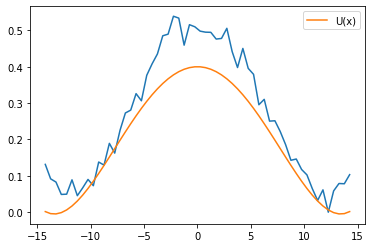

In [71]:
sns.lineplot(
    x=pmf_bin_centers[1:-1],
    y=(pmf_data[0][1:-1]-np.min(pmf_data[0][1:-1]))*kbT
)
sns.lineplot(
    x=pmf_bin_centers[1:-1],
    y=potFunTest(pmf_bin_centers[1:-1]),
    label='U(x)'
)
plt.show()